In [11]:
# CELL 1: imports & ROOT

from pathlib import Path
import glob
import json

import numpy as np
import cv2
import matplotlib.pyplot as plt

from ultralytics import YOLO  # YOLOv8

# >>>> EDIT THIS TO YOUR NEW DATASET FOLDER <<<<
ROOT = Path(r"C:\Users\mcsmu\Desktop\intersection")

print("ROOT:", ROOT)


ROOT: C:\Users\mcsmu\Desktop\intersection


In [12]:
# CELL 2: camera & LiDAR folders + sorted file lists

DATA_ROOT = ROOT

# Camera folders (edit if names differ in your new dataset)
IMG_S1_DIR = DATA_ROOT / "images" / "s110_camera_basler_south1_8mm"
IMG_S2_DIR = DATA_ROOT / "images" / "s110_camera_basler_south2_8mm"

# LiDAR folders
LIDAR_N_DIR = DATA_ROOT / "point_clouds" / "s110_lidar_ouster_north"
LIDAR_S_DIR = DATA_ROOT / "point_clouds" / "s110_lidar_ouster_south"

def sorted_files(folder: Path, pattern="*"):
    if not folder.exists():
        return []
    return sorted(folder.glob(pattern))

# Change to "*.png" if needed
img_s1_files = sorted_files(IMG_S1_DIR, "*.jpg")
img_s2_files = sorted_files(IMG_S2_DIR, "*.jpg")

lidar_n_files = sorted_files(LIDAR_N_DIR, "*.pcd")
lidar_s_files = sorted_files(LIDAR_S_DIR, "*.pcd")

print("South1 images:", len(img_s1_files))
print("South2 images:", len(img_s2_files))
print("North LiDAR frames:", len(lidar_n_files))
print("South LiDAR frames:", len(lidar_s_files))

if img_s1_files:
    print("Example South1:", img_s1_files[0])
if img_s2_files:
    print("Example South2:", img_s2_files[0])
if lidar_n_files:
    print("Example LiDAR North:", lidar_n_files[0])
if lidar_s_files:
    print("Example LiDAR South:", lidar_s_files[0])

if not img_s1_files or not img_s2_files or not lidar_n_files or not lidar_s_files:
    raise RuntimeError("Missing images or LiDAR frames. Check folder paths and extensions.")


South1 images: 2160
South2 images: 2160
North LiDAR frames: 2160
South LiDAR frames: 2160
Example South1: C:\Users\mcsmu\Desktop\intersection\images\s110_camera_basler_south1_8mm\1646667310_044372291_s110_camera_basler_south1_8mm.jpg
Example South2: C:\Users\mcsmu\Desktop\intersection\images\s110_camera_basler_south2_8mm\1646667310_055996268_s110_camera_basler_south2_8mm.jpg
Example LiDAR North: C:\Users\mcsmu\Desktop\intersection\point_clouds\s110_lidar_ouster_north\1646667310_042939725_s110_lidar_ouster_north.pcd
Example LiDAR South: C:\Users\mcsmu\Desktop\intersection\point_clouds\s110_lidar_ouster_south\1646667310_053239541_s110_lidar_ouster_south.pcd


In [13]:
# CELL 3: load YOLOv8 model (pretrained on COCO)

# You can switch to 'yolov8n.pt' for faster, or 'yolov8m.pt' for stronger
model = YOLO("yolov8s.pt")

print("YOLO model loaded.")


YOLO model loaded.


In [14]:
# CELL 4: load LiDAR -> camera projection matrices

CALIB_N_PATH = DATA_ROOT / "calibration" / "s110_lidar_ouster_north.json"
CALIB_S_PATH = DATA_ROOT / "calibration" / "s110_lidar_ouster_south.json"

print("North calib:", CALIB_N_PATH, "| Exists:", CALIB_N_PATH.exists())
print("South calib:", CALIB_S_PATH, "| Exists:", CALIB_S_PATH.exists())

with open(CALIB_N_PATH, "r") as f:
    calib_n = json.load(f)

with open(CALIB_S_PATH, "r") as f:
    calib_s = json.load(f)

# Adjust keys here if your new JSON uses different names
P_n_to_cam_s1 = np.array(
    calib_n["projection_matrix_into_s110_camera_basler_south1_8mm"],
    dtype=np.float32
)
P_n_to_cam_s2 = np.array(
    calib_n["projection_matrix_into_s110_camera_basler_south2_8mm"],
    dtype=np.float32
)

P_s_to_cam_s1 = np.array(
    calib_s["projection_matrix_into_s110_camera_basler_south1_8mm"],
    dtype=np.float32
)
P_s_to_cam_s2 = np.array(
    calib_s["projection_matrix_into_s110_camera_basler_south2_8mm"],
    dtype=np.float32
)

print("P_n_to_cam_s1 shape:", P_n_to_cam_s1.shape)
print("P_s_to_cam_s1 shape:", P_s_to_cam_s1.shape)
print("P_n_to_cam_s2 shape:", P_n_to_cam_s2.shape)
print("P_s_to_cam_s2 shape:", P_s_to_cam_s2.shape)


North calib: C:\Users\mcsmu\Desktop\intersection\calibration\s110_lidar_ouster_north.json | Exists: True
South calib: C:\Users\mcsmu\Desktop\intersection\calibration\s110_lidar_ouster_south.json | Exists: True
P_n_to_cam_s1 shape: (3, 4)
P_s_to_cam_s1 shape: (3, 4)
P_n_to_cam_s2 shape: (3, 4)
P_s_to_cam_s2 shape: (3, 4)


In [15]:
# CELL 5: function to load LiDAR .pcd as Nx3 XYZ

import open3d as o3d

def load_pcd_xyz(pcd_path: Path) -> np.ndarray:
    """
    Loads a .pcd file and returns Nx3 numpy array (XYZ only).
    """
    pcd = o3d.io.read_point_cloud(str(pcd_path))
    pts = np.asarray(pcd.points, dtype=np.float32)

    if pts.shape[0] == 0:
        print("WARNING: empty point cloud:", pcd_path)

    return pts


In [16]:
# CELL 6: projection and overlay utilities (strong visible colors)

def project_points_to_image(points_xyz, P, img_shape):
    """
    points_xyz: (N,3) in LiDAR coordinates
    P: 3x4 projection matrix (lidar -> camera)
    img_shape: (H, W, C)
    Returns: (u_px, v_px) as 1D int arrays and a boolean mask of valid points.
    """
    H, W = img_shape[:2]
    N = points_xyz.shape[0]

    ones = np.ones((N, 1), dtype=np.float32)
    pts_h = np.hstack([points_xyz.astype(np.float32), ones])  # (N,4)

    uvw = (P @ pts_h.T).T  # (N,3)
    u = uvw[:, 0]
    v = uvw[:, 1]
    w = uvw[:, 2]

    eps = 1e-6
    valid = w > eps

    u = u[valid] / w[valid]
    v = v[valid] / w[valid]

    in_img = (u >= 0) & (u < W) & (v >= 0) & (v < H)

    u_px = u[in_img].astype(np.int32)
    v_px = v[in_img].astype(np.int32)

    final_mask = np.zeros(N, dtype=bool)
    valid_idx = np.where(valid)[0][in_img]
    final_mask[valid_idx] = True

    return u_px, v_px, final_mask


def overlay_lidar_on_image(image_bgr, points_xyz, P,
                           color=(0, 255, 0),
                           stride=3,
                           radius=2):
    """
    Draw projected LiDAR points on the image with strong color.
    color: BGR tuple (e.g., (0,255,0) = bright green)
    stride: take every N-th point (for speed / density)
    radius: circle radius in pixels
    """
    if points_xyz.shape[0] == 0:
        return image_bgr

    if stride > 1:
        points_xyz = points_xyz[::stride]

    u_px, v_px, _ = project_points_to_image(points_xyz, P, image_bgr.shape)

    for x, y in zip(u_px, v_px):
        cv2.circle(image_bgr, (int(x), int(y)), radius, color, -1)

    return image_bgr



image 1/1 C:\Users\mcsmu\Desktop\intersection\images\s110_camera_basler_south1_8mm\1646667310_044372291_s110_camera_basler_south1_8mm.jpg: 416x640 2 persons, 6 cars, 1 truck, 39.6ms
Speed: 5.7ms preprocess, 39.6ms inference, 30.0ms postprocess per image at shape (1, 3, 416, 640)


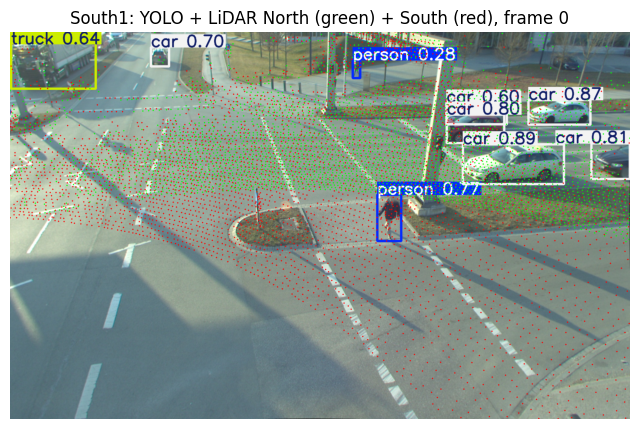


image 1/1 C:\Users\mcsmu\Desktop\intersection\images\s110_camera_basler_south2_8mm\1646667310_055996268_s110_camera_basler_south2_8mm.jpg: 416x640 6 cars, 1 bus, 1 truck, 23.1ms
Speed: 3.9ms preprocess, 23.1ms inference, 19.4ms postprocess per image at shape (1, 3, 416, 640)


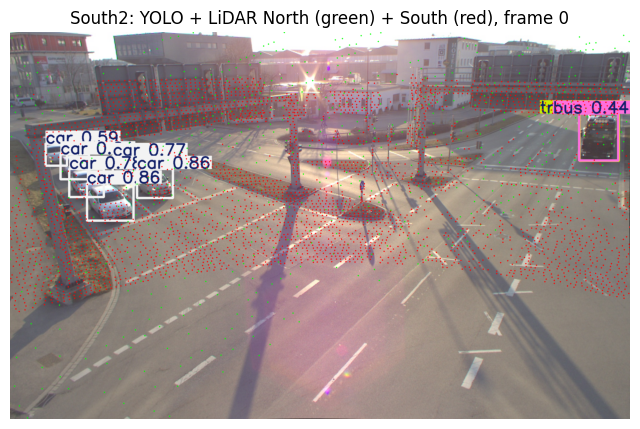

In [17]:
# CELL 7: YOLO + LiDAR overlay test on frame 0 (both cameras)

frame_idx = 0

# ---------- Camera South1 ----------
img1_path = img_s1_files[frame_idx]
img1_bgr = cv2.imread(str(img1_path))
if img1_bgr is None:
    raise RuntimeError(f"Failed to read image: {img1_path}")

# YOLO detection
res1 = model(str(img1_path))[0]
img1_det_bgr = res1.plot()  # YOLO draws boxes + labels

# LiDAR data
north_xyz = load_pcd_xyz(lidar_n_files[frame_idx])
south_xyz = load_pcd_xyz(lidar_s_files[frame_idx])

# Overlay LiDAR North (green) & South (red)
img1_overlay = img1_det_bgr.copy()
img1_overlay = overlay_lidar_on_image(
    img1_overlay,
    north_xyz,
    P_n_to_cam_s1,
    color=(0, 255, 0),  # GREEN
    stride=3,
    radius=2
)
img1_overlay = overlay_lidar_on_image(
    img1_overlay,
    south_xyz,
    P_s_to_cam_s1,
    color=(0, 0, 255),  # RED
    stride=3,
    radius=2
)

img1_rgb = cv2.cvtColor(img1_overlay, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8, 6))
plt.imshow(img1_rgb)
plt.axis("off")
plt.title(f"South1: YOLO + LiDAR North (green) + South (red), frame {frame_idx}")
plt.show()


# ---------- Camera South2 ----------
img2_path = img_s2_files[frame_idx]
img2_bgr = cv2.imread(str(img2_path))
if img2_bgr is None:
    raise RuntimeError(f"Failed to read image: {img2_path}")

res2 = model(str(img2_path))[0]
img2_det_bgr = res2.plot()

img2_overlay = img2_det_bgr.copy()
img2_overlay = overlay_lidar_on_image(
    img2_overlay,
    north_xyz,
    P_n_to_cam_s2,
    color=(0, 255, 0),
    stride=3,
    radius=2
)
img2_overlay = overlay_lidar_on_image(
    img2_overlay,
    south_xyz,
    P_s_to_cam_s2,
    color=(0, 0, 255),
    stride=3,
    radius=2
)

img2_rgb = cv2.cvtColor(img2_overlay, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8, 6))
plt.imshow(img2_rgb)
plt.axis("off")
plt.title(f"South2: YOLO + LiDAR North (green) + South (red), frame {frame_idx}")
plt.show()


In [18]:
# CELL 8: generate YOLO+LiDAR overlay frames AND combined video (left S2, right S1)

OUT_ROOT = ROOT / "output_yolo_lidar"
OUT_S1 = OUT_ROOT / "south1_overlay"
OUT_S2 = OUT_ROOT / "south2_overlay"

OUT_S1.mkdir(parents=True, exist_ok=True)
OUT_S2.mkdir(parents=True, exist_ok=True)

# Use all frames that exist in both image & LiDAR sets
num_frames = min(len(img_s1_files), len(img_s2_files),
                 len(lidar_n_files), len(lidar_s_files))

print("Total frames available:", num_frames)

# Prepare combined video writer (we'll init it after first valid frame)
COMBINED_VID = OUT_ROOT / "south2_left_south1_right_yolo_lidar.mp4"
writer = None
fps = 10  # change if you want faster/slower

for idx in range(num_frames):
    print(f"Frame {idx+1}/{num_frames}")

    # -------- South1 --------
    img1_path = img_s1_files[idx]
    img1_bgr = cv2.imread(str(img1_path))
    if img1_bgr is None:
        print(f"Warning: failed to read {img1_path}, skipping this frame")
        continue

    res1 = model(str(img1_path))[0]
    img1_det_bgr = res1.plot()

    # -------- LiDAR for this frame --------
    north_xyz = load_pcd_xyz(lidar_n_files[idx])
    south_xyz = load_pcd_xyz(lidar_s_files[idx])

    # YOLO + LiDAR overlay on South1
    img1_overlay = img1_det_bgr.copy()
    img1_overlay = overlay_lidar_on_image(
        img1_overlay,
        north_xyz,
        P_n_to_cam_s1,
        color=(0, 255, 0),  # GREEN
        stride=3,
        radius=2
    )
    img1_overlay = overlay_lidar_on_image(
        img1_overlay,
        south_xyz,
        P_s_to_cam_s1,
        color=(0, 0, 255),  # RED
        stride=3,
        radius=2
    )

    cv2.imwrite(str(OUT_S1 / f"frame_{idx:04d}.png"), img1_overlay)

    # -------- South2 --------
    img2_path = img_s2_files[idx]
    img2_bgr = cv2.imread(str(img2_path))
    if img2_bgr is None:
        print(f"Warning: failed to read {img2_path}, skipping this frame")
        continue

    res2 = model(str(img2_path))[0]
    img2_det_bgr = res2.plot()

    img2_overlay = img2_det_bgr.copy()
    img2_overlay = overlay_lidar_on_image(
        img2_overlay,
        north_xyz,
        P_n_to_cam_s2,
        color=(0, 255, 0),  # GREEN
        stride=3,
        radius=2
    )
    img2_overlay = overlay_lidar_on_image(
        img2_overlay,
        south_xyz,
        P_s_to_cam_s2,
        color=(0, 0, 255),  # RED
        stride=3,
        radius=2
    )

    cv2.imwrite(str(OUT_S2 / f"frame_{idx:04d}.png"), img2_overlay)

    # -------- Init video writer on first valid frame --------
    if writer is None:
        h1, w1, _ = img1_overlay.shape
        h2, w2, _ = img2_overlay.shape

        # Resize South2 overlay to match South1 if needed
        if (h1, w1) != (h2, w2):
            img2_overlay = cv2.resize(img2_overlay, (w1, h1))

        combined_h, combined_w = h1, w1 + img2_overlay.shape[1]
        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        writer = cv2.VideoWriter(str(COMBINED_VID), fourcc, fps, (combined_w, combined_h))
        print("Initialized VideoWriter with size:", combined_w, "x", combined_h)

    # -------- Write combined frame to video --------
    # Ensure same size again in case anything changed
    if img2_overlay.shape != img1_overlay.shape:
        img2_overlay = cv2.resize(img2_overlay, (img1_overlay.shape[1], img1_overlay.shape[0]))

    combined = cv2.hconcat([img2_overlay, img1_overlay])  # left = S2, right = S1
    writer.write(combined)

# Release writer if it was created
if writer is not None:
    writer.release()
    print("Saved combined YOLO+LiDAR video:", COMBINED_VID)
else:
    print("No valid frames processed; video not created.")


Total frames available: 2160
Frame 1/2160

image 1/1 C:\Users\mcsmu\Desktop\intersection\images\s110_camera_basler_south1_8mm\1646667310_044372291_s110_camera_basler_south1_8mm.jpg: 416x640 2 persons, 6 cars, 1 truck, 116.1ms
Speed: 5.2ms preprocess, 116.1ms inference, 22.9ms postprocess per image at shape (1, 3, 416, 640)

image 1/1 C:\Users\mcsmu\Desktop\intersection\images\s110_camera_basler_south2_8mm\1646667310_055996268_s110_camera_basler_south2_8mm.jpg: 416x640 6 cars, 1 bus, 1 truck, 23.2ms
Speed: 3.9ms preprocess, 23.2ms inference, 19.7ms postprocess per image at shape (1, 3, 416, 640)
Initialized VideoWriter with size: 3840 x 1200
Frame 2/2160

image 1/1 C:\Users\mcsmu\Desktop\intersection\images\s110_camera_basler_south1_8mm\1646667310_124279721_s110_camera_basler_south1_8mm.jpg: 416x640 2 persons, 7 cars, 1 truck, 25.3ms
Speed: 4.8ms preprocess, 25.3ms inference, 24.4ms postprocess per image at shape (1, 3, 416, 640)

image 1/1 C:\Users\mcsmu\Desktop\intersection\images\s11